In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss

In [2]:
%%time
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

Wall time: 2min 43s


In [3]:
df.head()

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag
0,0,2008-2009,div0,1.73,3.5,5.00,5,3,7,8,...,3.825,11.00,7.665,6.377,5.908,0.500,3.0,0,0,1
1,1,2008-2009,div0,1.25,5.5,12.00,7,0,2,5,...,3.582,2.10,2.250,2.833,2.475,0.333,0.0,0,1,0
2,2,2008-2009,div0,1.57,3.8,5.75,9,1,4,4,...,3.525,6.75,4.275,3.883,3.638,0.750,1.5,1,0,0
3,3,2008-2009,div0,1.17,7.0,15.00,11,2,6,7,...,3.975,4.20,2.750,2.333,2.550,0.600,0.0,1,0,0
4,4,2008-2009,div0,1.17,7.0,15.00,14,2,4,7,...,3.925,3.10,2.175,2.050,2.015,0.833,0.0,1,0,0


In [4]:
x_variables = set(df.columns)

In [5]:
remove = set(['home_win_flag', 'draw_flag', 'away_win_flag', 'match_id'])

In [6]:
x_variables = list(x_variables - remove)

In [7]:
len(x_variables)

163

In [8]:
df_train, df_holdout = train_test_split(df, train_size=0.8, random_state=2023)

In [9]:
print(df_train.shape[0])
print(df_holdout.shape[0])

51332
12834


### home win flag

In [34]:
y, X = dmatrices("home_win_flag ~ " + " + ".join(x_variables), df_train)

In [35]:
y.shape

(51332, 1)

In [36]:
rfc = RandomForestClassifier(random_state = 2023)

In [39]:
tune_grid = {"max_features": [6, 8, 10, 12, 14, 16], 
             'max_depth': [4, 6, 8, 10],
             "min_samples_leaf": [5, 10, 15, 20]}

In [38]:
import math
math.sqrt(len(x_variables))

12.767145334803704

In [40]:
rf_random = GridSearchCV(
    rfc,
    tune_grid,
    cv=5,
    scoring= 'roc_auc', 
    verbose=3,
)

In [42]:
%%time

print(datetime.datetime.now())
rf_model = rf_random.fit(X, y.ravel())

2023-02-26 18:49:31.876837
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END max_depth=4, max_features=6, min_samples_leaf=5;, score=0.669 total time=   3.7s
[CV 2/5] END max_depth=4, max_features=6, min_samples_leaf=5;, score=0.668 total time=   3.6s
[CV 3/5] END max_depth=4, max_features=6, min_samples_leaf=5;, score=0.669 total time=   3.5s
[CV 4/5] END max_depth=4, max_features=6, min_samples_leaf=5;, score=0.671 total time=   3.6s
[CV 5/5] END max_depth=4, max_features=6, min_samples_leaf=5;, score=0.673 total time=   3.4s
[CV 1/5] END max_depth=4, max_features=6, min_samples_leaf=10;, score=0.669 total time=   3.6s
[CV 2/5] END max_depth=4, max_features=6, min_samples_leaf=10;, score=0.668 total time=   3.5s
[CV 3/5] END max_depth=4, max_features=6, min_samples_leaf=10;, score=0.669 total time=   3.5s
[CV 4/5] END max_depth=4, max_features=6, min_samples_leaf=10;, score=0.671 total time=   3.5s
[CV 5/5] END max_depth=4, max_features=6, min_samples_leaf=10

In [43]:
rf_model.cv_results_

{'mean_fit_time': array([ 3.50051756,  3.43850956,  3.49151793,  3.45939155,  4.25008078,
         4.42010255,  4.75461769,  4.76217151,  5.28337631,  5.16299138,
         5.2135551 ,  5.57647986,  6.59019451,  6.25770721,  6.64493546,
         6.46143756,  7.21489024,  7.42831974,  6.91210384,  7.43760867,
         7.68248043,  7.6700346 ,  7.62009711,  7.60667176,  4.8055603 ,
         4.69024248,  4.73424606,  4.68115578,  5.91433177,  5.85218182,
         5.99096284,  5.9792974 ,  7.15452795,  7.01019888,  7.01509542,
         7.53077412,  9.4740746 ,  8.45278945,  8.34974327,  8.26400146,
         9.72379103,  9.45296254, 10.94603877, 11.10431633, 11.53468347,
        11.74015512, 11.94468718, 11.59424143,  6.29188972,  6.28146405,
         6.33370638,  6.50579786,  8.03760486,  7.98801551,  8.06324105,
         8.20137596,  9.75207825,  9.52788095,  9.65036407,  9.80121527,
        11.36881514, 11.29612174, 12.12426782, 11.69467335, 13.07053766,
        12.32883487, 11.88318558, 

In [44]:
rf_model.best_score_

0.677321401632606

In [45]:
rf_model.best_params_

{'max_depth': 8, 'max_features': 16, 'min_samples_leaf': 15}

In [46]:
rf_model.best_estimator_

RandomForestClassifier(max_depth=8, max_features=16, min_samples_leaf=15,
                       random_state=2023)

In [47]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [48]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,odds_away_team_win,14.2%,14.2%
1,odds_home_team_win,13.6%,27.9%
2,odds_home_team_defeat_roll4_mean,4.2%,32.0%
3,odds_draw,3.9%,35.9%
4,odds_away_team_win_roll4_mean,3.4%,39.3%
5,away_team_expected_point_mean,3.4%,42.6%
6,odds_home_team_win_roll4_mean,3.2%,45.8%
7,odds_home_team_defeat_roll3_mean,3.1%,48.9%
8,odds_away_team_defeat_roll4_mean,2.3%,51.2%
9,odds_home_team_win_roll2_mean,2.1%,53.3%


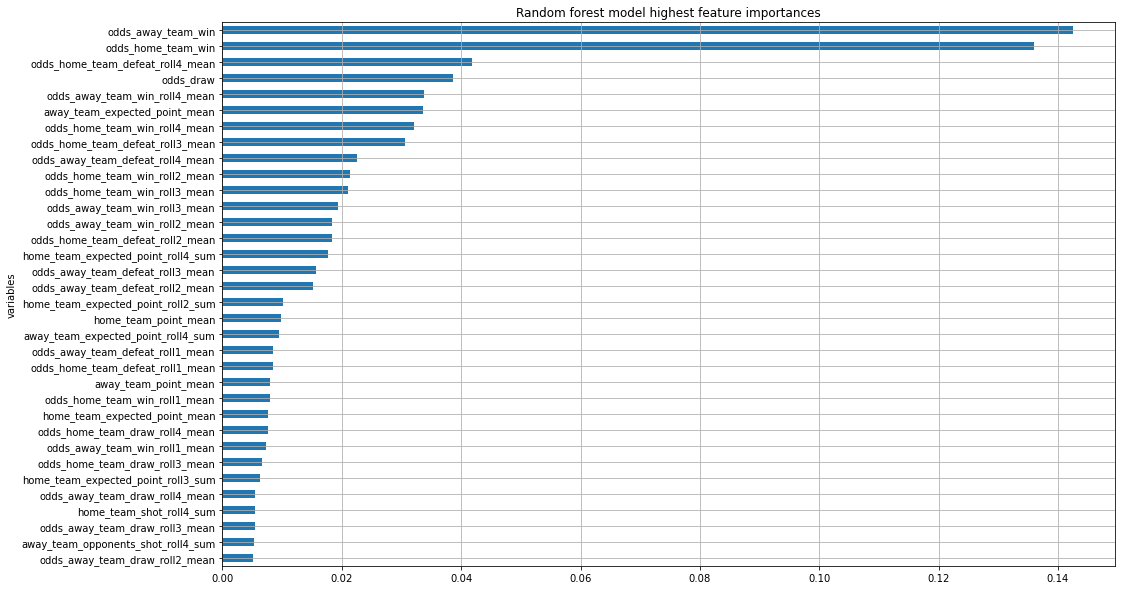

In [51]:
df_var_imp[df_var_imp.imp > 0.005]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (16,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

### away win flag

In [10]:
y, X = dmatrices("away_win_flag ~ " + " + ".join(x_variables), df_train)

In [11]:
rfc = RandomForestClassifier(random_state = 2023)

In [12]:
tune_grid = {"max_features": [14, 16], 
             'max_depth': [8, 10],
             "min_samples_leaf": [15]}

In [13]:
rf_random_away = GridSearchCV(
    rfc,
    tune_grid,
    cv=5,
    scoring= 'roc_auc', 
    verbose=3,
)

In [14]:
%%time

print(datetime.datetime.now())
rf_model_away = rf_random_away.fit(X, y.ravel())

2023-03-01 11:54:55.566944
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=8, max_features=14, min_samples_leaf=15;, score=0.678 total time=  17.0s
[CV 2/5] END max_depth=8, max_features=14, min_samples_leaf=15;, score=0.689 total time=  18.0s
[CV 3/5] END max_depth=8, max_features=14, min_samples_leaf=15;, score=0.680 total time=  14.3s
[CV 4/5] END max_depth=8, max_features=14, min_samples_leaf=15;, score=0.690 total time=  12.7s
[CV 5/5] END max_depth=8, max_features=14, min_samples_leaf=15;, score=0.678 total time=  12.5s
[CV 1/5] END max_depth=8, max_features=16, min_samples_leaf=15;, score=0.679 total time=  14.3s
[CV 2/5] END max_depth=8, max_features=16, min_samples_leaf=15;, score=0.689 total time=  13.7s
[CV 3/5] END max_depth=8, max_features=16, min_samples_leaf=15;, score=0.682 total time=  14.1s
[CV 4/5] END max_depth=8, max_features=16, min_samples_leaf=15;, score=0.691 total time=  16.6s
[CV 5/5] END max_depth=8, max_features=16, min_sa

In [15]:
df_var_imp_away = pd.DataFrame(
    rf_model_away.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp_away['cumulative_imp'] = df_var_imp_away['imp'].cumsum()

In [16]:
df_var_imp_away.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,odds_home_team_win,14.6%,14.6%
1,odds_away_team_win,11.9%,26.4%
2,away_team_expected_point_mean,4.7%,31.1%
3,odds_away_team_win_roll4_mean,3.8%,34.9%
4,odds_home_team_defeat_roll4_mean,3.6%,38.5%
5,odds_draw,3.3%,41.7%
6,odds_home_team_defeat_roll3_mean,3.0%,44.7%
7,odds_home_team_win_roll4_mean,2.8%,47.5%
8,odds_away_team_defeat_roll4_mean,2.3%,49.8%
9,odds_away_team_win_roll2_mean,2.3%,52.1%


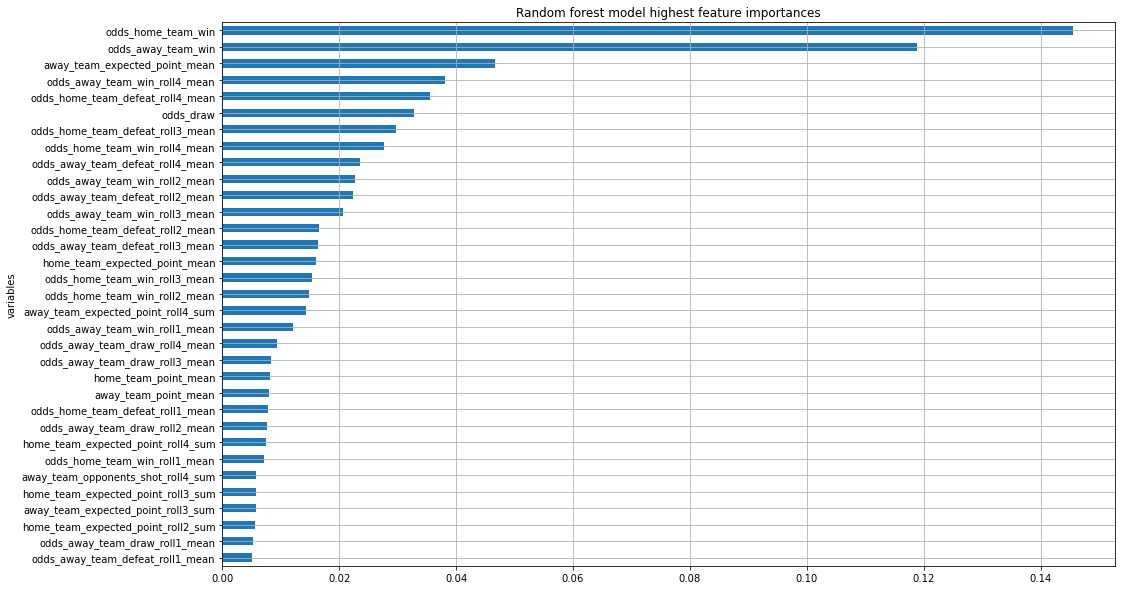

In [18]:
df_var_imp_away[df_var_imp_away.imp > 0.005]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (16,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );